### Define all functions

In [1]:
# Make models

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import random
from pathlib import Path
import os
import json
import cv2
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch
import matplotlib.pyplot as plt
from transformers import DetrImageProcessor

def make_model_processor(dir_path):

    dir_path = dir_path

    class Detr(pl.LightningModule):
        def __init__(self, lr, lr_backbone, weight_decay):
            super().__init__()
            # replace COCO classification head with custom head
            # we specify the "no_timm" variant here to not rely on the timm library
            # for the convolutional backbone
            self.model = DetrForObjectDetection.from_pretrained(dir_path,
                                                                revision="no_timm",
                                                                num_labels=1,
                                                                ignore_mismatched_sizes=True)
            # Set all parameters as trainable
            for param in self.model.parameters():
                param.requires_grad = True

            # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
            self.lr = lr
            self.lr_backbone = lr_backbone
            self.weight_decay = weight_decay

        def forward(self, pixel_values, pixel_mask):
            outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

            return outputs

        def common_step(self, batch, batch_idx):
            pixel_values = batch["pixel_values"]
            pixel_mask = batch["pixel_mask"]
            labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

            outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

            loss = outputs.loss
            loss_dict = outputs.loss_dict

            return loss, loss_dict

        def training_step(self, batch, batch_idx):
            loss, loss_dict = self.common_step(batch, batch_idx)
            # logs metrics for each training_step,
            # and the average across the epoch
            self.log("training_loss", loss)
            for k, v in loss_dict.items():
                self.log("train_" + k, v.item())

            return loss

        def validation_step(self, batch, batch_idx):
            loss, loss_dict = self.common_step(batch, batch_idx)
            self.log("validation_loss", loss)
            for k, v in loss_dict.items():
                self.log("validation_" + k, v.item())

            return loss

        def configure_optimizers(self):
            param_dicts = [
                {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
                {
                    "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                    "lr": self.lr_backbone,
                },
            ]
            optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                          weight_decay=self.weight_decay)

            return optimizer

        def train_dataloader(self):
            return train_dataloader

        def val_dataloader(self):
            return val_dataloader

    # make preprocessor
    processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

    # Make model object as per above class
    model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
    
    return model, processor

In [2]:
# Load the best checkpoint
def load_checkpoint(checkpoint_path):
    checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))

    # Load the model state dictionary from the checkpoint
    model.load_state_dict(checkpoint['state_dict'])


In [3]:
## Load test videos ::
# For leaderboard, load videos first

def load_test_videos(path):
    """
    This function returns all trainings videos and the annotations as binary masks (1 at the positions where a Hexbug is located).
    All frames are resized and normalized. 
    """
    X = []
    i=0
    for vid in os.listdir(path):

        path = Path(path)
        if ".mp4" in vid:
            temp_save = []
            
            cap = cv2.VideoCapture(str(path / vid))
            ret, frame = cap.read()     
            org_shape = frame.shape    
            
            z = 0  # frame counter
            while ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame_history = []
                
                # Append to lists
                temp_save.append(frame)
                
                ret, frame = cap.read()  # read next frame
                z += 1  # increase frame counter
            X.append(temp_save)

    X = (X)
    
    return X


In [4]:
# Initial prediction before association algorithm

def get_initial_predictions(X, threshold):

    threshold = threshold
    initial_predictions = []
    predicted_hex = []

    for video in X:

        tmp = []

        for i, img in enumerate(video):

            #We can use the image_id in target to know which image it is
            encoding = processor(images=img, annotations=None, return_tensors="pt")
            pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension

            device = torch.device( "cuda")
            pixel_values = pixel_values.unsqueeze(0).to(device)
            model.to(device)

            with torch.no_grad():
              # forward pass to get class logits and bounding boxes
              outputs = model(pixel_values=pixel_values, pixel_mask=None)

            # postprocess model outputs
            width, height = img.shape[1], img.shape[0]
            postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                            target_sizes=[(height, width)],
                                                                            threshold=threshold)
            results = postprocessed_outputs[0]


            for ids, (score, label, (xmin, ymin, xmax, ymax))  in enumerate(zip(results['scores'].tolist(), results['labels'].tolist(), results['boxes'].tolist())):
                center = (xmin+32.5, ymin+32.5)
                array = [int(i),int(ids),xmin+32.5, ymin+32.5]
                np.set_printoptions(suppress=True)
                farray = np.array(array)

                frame, ids, x ,y = farray

                if int(ids+1)<=4: 
                    # we create a dictionary for each roi in the correct format
                    e = {
                            't': frame,
                            'hexbug': ids,
                            'x': y,
                            'y': x
                        }
                    tmp.append(e)

        total_frames = int(i)+1
        n = round(len(tmp)/total_frames)
        predicted_hex.append(n)

        initial_predictions.append(tmp)
        
    return initial_predictions, predicted_hex


In [5]:
def calculate_distance(x1, y1, x2, y2):
    return ((x2 - x1)**2 + (y2 - y1)**2)

In [6]:
# Final predictions after applying associative alogorithm

def get_final_predictions(X, threshold, predicted_hex):
    threshold = threshold
    final_predictions = []
    n_hex = predicted_hex

    for m, video in enumerate(X):

        tmp = []
        tmp_array = []

        for i, img in enumerate(video):

            #We can use the image_id in target to know which image it is
            encoding = processor(images=img, annotations=None, return_tensors="pt")
            pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension

            device = torch.device( "cuda")
            pixel_values = pixel_values.unsqueeze(0).to(device)
            model.to(device)

            with torch.no_grad():
              # forward pass to get class logits and bounding boxes
              outputs = model(pixel_values=pixel_values, pixel_mask=None)

            # postprocess model outputs
            width, height = img.shape[1], img.shape[0]
            postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                            target_sizes=[(height, width)],
                                                                            threshold=threshold)
            results = postprocessed_outputs[0]

            image_pred_history = []
            for ids, (score, label, (xmin, ymin, xmax, ymax))  in enumerate(zip(results['scores'].tolist(), results['labels'].tolist(), results['boxes'].tolist())):
                pred_n_hexs = len(results['scores'].tolist())
                center = (xmin+32.5, ymin+32.5)
                array = [int(i),int(ids),xmin+32.5, ymin+32.5]
                farray = np.array(array)
                frame, ids, x ,y = farray

                if int(ids+1)<=n_hex[m]:
                    if int(ids+1)<=4: 
                        # we create a dictionary for each roi in the correct format
                        e = {
                                't': frame,
                                'hexbug': ids,
                                'x': y,
                                'y': x
                            }
                        image_pred_history.append(farray)
                        tmp.append(e)

            tmp_array.append(image_pred_history)

            if (int(ids+1)<n_hex[m]):
                difference = n_hex[m] - int(ids+1)
                for n in range(len(tmp_array) - 1, -1, -1):
                    if len(tmp_array[n]) == n_hex[m]:

                        associative_list = []
                        a_list = tmp_array[n]
                        # Iterate over elements of list B
                        for b_element in image_pred_history:
                            min_distance = float('inf')  # Initialize minimum distance as infinity
                            associated_a_element = None  # Initialize associated A element as None

                            # Iterate over elements of list A
                            for index, a_element in enumerate(a_list):
                                if not index in associative_list:
                                    # Extract frame ID, hexbug ID, x, and y coordinates from list A element
                                    a_frame_id, a_hexbug_id, a_x, a_y = a_element

                                    # Calculate distance between B element and A element
                                    distance = calculate_distance(a_x, a_y, b_element[2], b_element[3])

                                    # Check if the distance is smaller than the minimum distance
                                    if distance < min_distance:
                                        min_distance = distance
                                        associated_a_element = a_element
                                        associated_a_element_index = index
                            associative_list.append(associated_a_element_index)                        

                        expected_size = n_hex[m]
                        expected_range = range(0, expected_size)
                        missing_elements = list(set(expected_range) - set(associative_list))

                        for missed_number, missed in enumerate(missing_elements):                     
                            x = tmp_array[n][missed][2]
                            y = tmp_array[n][missed][3]
                            e = {
                            't': int(frame),
                            'hexbug': int(ids+missed_number+1),
                            'x': y,
                            'y': x}
                            tmp.append(e)
                        break

                    else:
                        pass



        final_predictions.append(tmp)
        
    return final_predictions


In [7]:
# Saving function to generate csv files
import pandas as pd
def save_list(list_with_values: list, path: str):
    df = pd.DataFrame(list_with_values)
    df = df.sort_values(by = ['hexbug', 't'],ignore_index=True) # we sort the values by hexbug and frame
    # now the values are in the correct order, so we save the csv file
    print('Saving to csv')
    df.to_csv(path)
    print('Done')

In [8]:
dir_path = "C:/Salil Data/Salil/Salil FAU/MSc ACES/Sem 2 Courses/Tracking Olympiad/Trained/DETR resnet50 default/Full_trainable/5_queries/auxloss_true"
# dir_path = "C:/Salil Data/Salil/Salil FAU/MSc ACES/Sem 2 Courses/Tracking Olympiad/Trained/DETR resnet50 default/Full_trainable/5_queries/auxloss_true/bboxloss_inc/Gaussian_Color/V30_resnet101"
model, processor = make_model_processor(dir_path)

C:\Users\salil\anaconda3\lib\site-packages\transformers\models\detr\image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at C:/Salil Data/Salil/Salil FAU/MSc ACES/Sem 2 Courses/Tracking Olympiad/Trained/DETR resnet50 default/Full_trainable/5_queries/auxloss_true and are newly initialized because the shapes did not match:
- model.query_position_embeddings.weight: found shape torch.Size([100, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
checkpoint_path = "C:/Salil Data/Salil/Salil FAU/MSc ACES/Sem 2 Courses/Tracking Olympiad/Trained/DETR resnet50 default/Full_trainable/5_queries/auxloss_true/bboxloss_inc/logstensorboard/DETR_Full_trainable_ogr_size_5_queries/version_2/checkpoints/epoch=24-step=3700.ckpt"
load_checkpoint(checkpoint_path)

In [10]:
# Directory where test videos are located
dir_path_videos = 'C:/Salil Data/Salil/Salil FAU/MSc ACES/Sem 2 Courses/Tracking Olympiad/Leaderboard test data/videos'

# Define path where the test data is located
path_test_vids = Path(dir_path_videos)
X = load_test_videos(dir_path_videos)

In [11]:
len(X)

5

In [12]:
initial_predictions, predicted_hex = get_initial_predictions(X, 0.65)

In [13]:
initial_predictions

[[{'t': 0.0, 'hexbug': 0.0, 'x': 278.9590606689453, 'y': 1021.1066284179688},
  {'t': 0.0, 'hexbug': 1.0, 'x': 154.98894500732422, 'y': 331.859130859375},
  {'t': 0.0, 'hexbug': 2.0, 'x': 1034.2057495117188, 'y': 314.41424560546875},
  {'t': 1.0, 'hexbug': 0.0, 'x': 149.13597106933594, 'y': 240.2507781982422},
  {'t': 1.0, 'hexbug': 1.0, 'x': 402.3254089355469, 'y': 998.3319091796875},
  {'t': 1.0, 'hexbug': 2.0, 'x': 1048.4156494140625, 'y': 197.81752014160156},
  {'t': 2.0, 'hexbug': 0.0, 'x': 145.5897674560547, 'y': 127.4078369140625},
  {'t': 2.0, 'hexbug': 1.0, 'x': 518.7676696777344, 'y': 909.627197265625},
  {'t': 2.0, 'hexbug': 2.0, 'x': 1038.2164916992188, 'y': 124.62207794189453},
  {'t': 3.0, 'hexbug': 0.0, 'x': 120.20895385742188, 'y': 33.349528670310974},
  {'t': 3.0, 'hexbug': 1.0, 'x': 602.7911376953125, 'y': 828.1036987304688},
  {'t': 3.0, 'hexbug': 2.0, 'x': 973.5535888671875, 'y': 51.39643478393555},
  {'t': 4.0, 'hexbug': 0.0, 'x': 95.45536041259766, 'y': 34.9766874

In [65]:
(predicted_hex)

[3, 1, 3, 3, 3]

In [66]:
# predicted_hex[0] = 2

In [67]:
(predicted_hex)

[3, 1, 3, 3, 3]

In [68]:
final_predictions = get_final_predictions(X, 0.65, predicted_hex)

In [69]:
# final_predictions

In [70]:
# Save predictions

for i, prediction in enumerate(final_predictions):
    save_list(prediction, f"C:\\Salil Data\\Salil\\Salil FAU\\MSc ACES\\Sem 2 Courses\\Tracking Olympiad\\Leaderboard test data\\videos\\test00{i+1}.csv")

Saving to csv
Done
Saving to csv
Done
Saving to csv
Done
Saving to csv
Done
Saving to csv
Done


In [71]:
import sys
sys.path.append("C:\Salil Data\Salil\Salil FAU\MSc ACES\Sem 2 Courses\\Tracking Olympiad\\Git Repository")

from traco_external import get_score
from traco_external.get_score import *

total_score = 0
for i in range(len(final_predictions)):
    score = get_score(f"C:/Salil Data/Salil/Salil FAU/MSc ACES/Sem 2 Courses/Tracking Olympiad/Leaderboard test data/videos/test00{i+1}.csv", f"C:/Salil Data/Salil/hexbugtest/gt/test00{i+1}.csv", log=True)
    print("Score for Video :", i+1, "is :", score)
    total_score += score
print("Total score :           ", total_score)

Score for Video : 1 is : 12074.967777515163
Score for Video : 2 is : 780.8893762497265
Score for Video : 3 is : 107609.820368868
Score for Video : 4 is : 14508.24232231819
Score for Video : 5 is : 133358.14230055085
Total score :            268332.06214550196


In [56]:
# V28 - Score 14398 Resnet 50, train data 6

# V27 - Score 20194.9 Resnet 50, train data 5

# V30 - Score 19938.6 Resnet 101, train data 6

# V2 - Score 268332.0, Resnet 50, initial train data




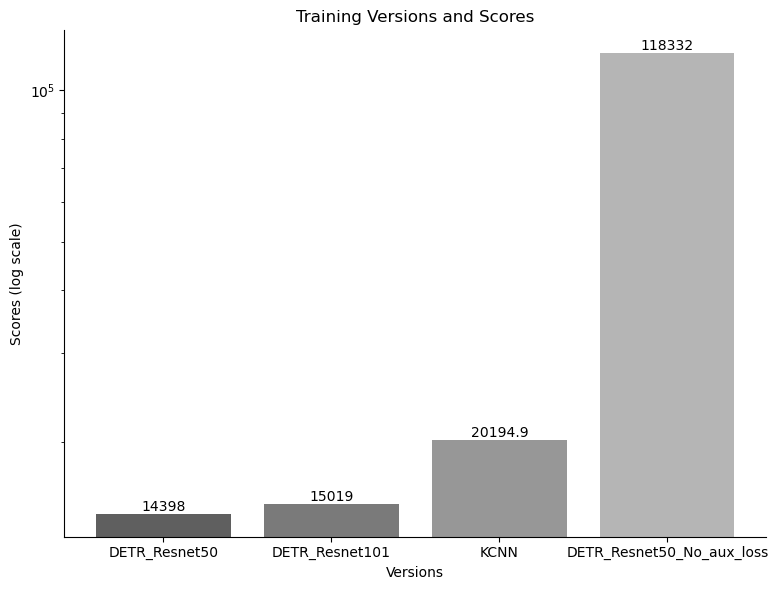

In [89]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Data
versions = ['DETR_Resnet50', 'DETR_Resnet101', 'KCNN', 'DETR_Resnet50_No_aux_loss']
scores = [14398, 15019, 20194.9, 118332 ]
# Create the 'viridis' colormap
colors = cm.Greys_r([0.3, 0.4, 0.5, 0.6])

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(versions, scores, color=colors)
plt.yscale('log')  # Logarithmic scale for the y-axis
plt.xlabel('Versions')
plt.ylabel('Scores (log scale)')
plt.title('Training Versions and Scores')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)

# Display the scores above the bars
for i, score in enumerate(scores):
    plt.text(i, score, str(score), ha='center', va='bottom')
    

# Remove right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout()
plt.show()
